# Linear System experiment

### Importing libraries

In [1]:
import numpy as np
import scipy
import pickle
import torch
import copy

from randomizedRRR.dual import fit_reduced_rank_regression_tikhonov as fit_R3
from randomizedRRR.dual import fit_rand_reduced_rank_regression_tikhonov as fit_R4
from randomizedRRR.utils import tonp, frnp
from randomizedRRR.kernels import LinearKernel
from sklearn.model_selection import ParameterGrid
from scipy.special import expit
from scipy.linalg import eig
from tqdm import tqdm
from time import perf_counter

### Defining some functions

In [2]:
def error_bound(x, y, params, num_repetitions):
    n = x.shape[0]
    kernel = LinearKernel()
    K_X = kernel(x)
    K_Y = kernel(y)
    K_YX = kernel(y, x)
    args = {'K_X':K_X, 'K_Y':K_Y, 'tikhonov_reg':params['tikhonov_reg'], 'rank':params['rank'], 'svd_solver':'full',
            '_return_singular_values':True}
    U_R3, V_R3, svals_sq_R3 = fit_R3(**args)
    evals_R3  = estimator_eig(U_R3, V_R3, K_YX)
    if params['optimal_sketching']:
        covariance_norm = None
    else:
        inv_n = n ** -1
        K_Y = kernel(y)
        covariance_norm = tonp(inv_n * torch.linalg.norm(K_Y, ord=2), cuda)
    risk_delta = np.zeros(num_repetitions)
    evals_R4 = np.zeros((num_repetitions, params['rank']))
    for rep_idx in range(num_repetitions):
        U_R4, V_R4, svals_sq_R4 = fit_R4(K_X=K_X, K_Y=K_Y, tikhonov_reg=params['tikhonov_reg'], rank=params['rank'],
                                         n_oversamples=params['n_oversamples'], iterated_power=params['iterated_power'],
                                         optimal_sketching=params['optimal_sketching'], rng_seed=rep_idx,
                                         _return_singular_values=True)
        evals_R4[rep_idx, :] = estimator_eig(U_R4, V_R4, K_YX)
        risk_delta[rep_idx] = risk(U_R4, V_R4, x, y, kernel) - risk(U_R3, V_R3, x, y, kernel)
    return theoretical_error_estimate(svals_sq_R3, params['rank'], params['n_oversamples'], params['iterated_power'], covariance_norm), risk_delta, evals_R3, evals_R4

def theoretical_error_estimate(svals_sq, rank, n_oversamples, iterated_power, covariance_norm = None):
    #Variable renaming to be consistend with paper notation (Theorems 2 and 3).
    svals_sq = np.sort(svals_sq)[::-1]
    r = rank
    s = float(n_oversamples)
    p = iterated_power
    if covariance_norm is not None:
        L = covariance_norm
        svals_normed = svals_sq/svals_sq[r-1] #renormalization by sigma_{r + 1}
        svals_pre = svals_normed[:r]**-1 #Invert to use in the def of a_r and b_r
        svals_post = svals_normed[r:]
        c_r = np.sum(svals_post**(2*p))*L
        a_r = (svals_sq[r-1]**-1)*c_r*( 1 + ((s - 1)**(-1))*np.sum(svals_pre**(2*p + 1)))
        b_r = c_r*(svals_sq[0]/svals_sq[r-1] + ((s - 1)**(-1))*np.sum(svals_pre**(2*p)))
    else:
        svals_normed = svals_sq/svals_sq[r] #renormalization by sigma_{r + 1}
        svals_pre = svals_normed[:r]**-1 #Invert to use in the def of a_r and b_r
        svals_post = svals_normed[r:]
        a_r = ((s - 1)**(-1))*np.sum(svals_pre**(2*p + 1))*np.sum(svals_post**(2*p + 1))
        b_r = (svals_sq[r])*((s - 1)**(-1))*np.sum(svals_pre**(2*p))*np.sum(svals_post**(2*p + 1))
    a = (r*a_r*svals_sq[0])/(r + a_r)
    return np.minimum(a, b_r)

def benchmark_loop(x, y, param_grid):
    results = []
    for optimal_sketching in [True, False]:
        num_parameters = len(param_grid)
        theoretical_estimate = np.zeros(num_parameters)
        empirical_estimate_mean = np.zeros(num_parameters)
        empirical_estimate_std = np.zeros(num_parameters)
        risk_deltas = []
        for idx, params in tqdm(enumerate(param_grid), total=num_parameters):
            params['optimal_sketching'] = optimal_sketching
            th_estimate, risk_delta, evals_R3, evals_R4 = error_bound(x, y, params, num_repetitions)
            theoretical_estimate[idx] = th_estimate
            risk_deltas.append(risk_delta)
            empirical_estimate_mean[idx] = np.mean(risk_delta)
            empirical_estimate_std[idx] = np.std(risk_delta)
        results.append({
            'th_estimate': theoretical_estimate.copy(),
            'means': empirical_estimate_mean.copy(),
            'stds': empirical_estimate_std.copy(),
            'evals_R3': evals_R3,
            'evals_R4': evals_R4,
            'risk_deltas': risk_deltas
        })
    return results

def risk(U, V, X, Y, kernel=None, Xtest=None, Ytest=None):
    inv_n = X.shape[0] ** -1
    if (Xtest is not None) and (Ytest is not None):
        K_Xtest = kernel(X, Xtest)
        Y_hat = inv_n * (K_Xtest.T @ V @ U.T @ Y)
        Y = Ytest
    else:
        K_X = kernel(X)
        Y_hat = inv_n * (K_X.T @ V @ U.T @ Y)
    err = Y - Y_hat
    return (err.shape[0] ** -1) * torch.trace(err@err.T)

# I will realize a prototypical low-rank matrix using a sigmoid function
def make_rand_mat(dim, decay_len, rank, seed = None):
    x = np.arange(dim)
    x-= rank
    eigenvalues = expit(-x*6/decay_len)
    U = scipy.stats.special_ortho_group.rvs(dim, random_state=seed)
    return np.linalg.multi_dot([U, np.diag(eigenvalues), U.T])

def make_dataset(mat, num_samples, sigma = 0.05, seed = None):
    dim = mat.shape[0]
    rng = np.random.default_rng(seed)
    X = rng.multivariate_normal(np.zeros(dim), np.eye(dim), size=num_samples)
    Y = (mat@X.T).T + rng.normal(0, sigma, size=(num_samples, dim))
    return frnp(X,device,dtype), frnp(Y,device,dtype)

def time_fn_execution(f, args, num_repetitions):
    times = np.zeros(num_repetitions)
    risk_train = np.zeros(num_repetitions)
    risk_test = np.zeros(num_repetitions)
    for rep_idx in tqdm(np.arange(num_repetitions), total=num_repetitions):
        if 'rng_seed' in args.keys():
            args['rng_seed'] = rep_idx
        _start = perf_counter()
        U, V = f(**args) #time it
        _stop = perf_counter()
        times[rep_idx] = _stop - _start
        risk_train[rep_idx] = risk(U, V, X, Y, kernel=kernel)
        risk_test[rep_idx] = risk(U, V, X, Y, kernel=kernel, Xtest=Xtest, Ytest=Ytest)
    return times, risk_train, risk_test

def estimator_eig(
        U: torch.TensorType,  # Projection matrix: first output of the fit functions defined above
        V: torch.TensorType,  # Projection matrix: second output of the fit functions defined above
        K_YX: torch.TensorType  # Kernel matrix between the output data and the input data
) -> torch.TensorType:
    # Z.TUV.TS -> U.T K_YX V (right ev = SUvr, left ev = ZVvl)
    r_dim = (K_YX.shape[1]) ** (-1)
    W_YX = torch.linalg.multi_dot([U.T, r_dim * K_YX, V])
    values, _ = eig(tonp(W_YX, cuda))
    values = values.real
    r_perm = np.argsort(values)
    values = values[r_perm]
    return values

### Running first experiment (Figure 1)

In [4]:
cuda = False
double_precision = True
device = 'cuda' if cuda else 'cpu'
torch.set_default_device(device)
dtype = torch.DoubleTensor if double_precision else torch.FloatTensor
torch.set_default_tensor_type(dtype)

seed = 0
num_repetitions = 1000
ndim = 100
num_samples = 1000
decay_len = 5
rank = 10

#Generation of the low-rank estimator A + Generation of the dataset
A = make_rand_mat(ndim, decay_len, rank, seed=seed)
X, Y = make_dataset(A, num_samples, sigma=0.1, seed=seed)

#Parameter grid
looping_parameters = [
    {'name': 'rank',
     'human_name': 'Rank',
                   'params_grid': ParameterGrid({'tikhonov_reg': [1e-6],
                    'rank': np.arange(11, dtype=int) + 5,
                    'n_oversamples': [5],
                    'iterated_power': [1]})},
    {'name': 'n_oversamples',
     'human_name': r'Oversamples $s$',
                   'params_grid': ParameterGrid({'tikhonov_reg': [1e-6],
                    'rank': [5],
                    'n_oversamples': np.arange(9, dtype=int) + 2,
                    'iterated_power': [1]})}
]

results = copy.deepcopy(looping_parameters)
for idx, parameter in enumerate(looping_parameters):
    print(f"Currently processing: {parameter['name']}")
    results[idx]['results'] = benchmark_loop(X, Y, parameter['params_grid'])

pickle.dump(results, open('randRRR_errorbounds_dual_'+device+'.pkl', 'wb'))

Currently processing: rank


  0%|          | 0/11 [00:00<?, ?it/s]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
  9%|▉         | 1/11 [02:20<23:25, 140.56s/it]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
 18%|█▊        | 2/11 [04:39<20:57, 139.73s/it]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
 27%|██▋       | 3/11 [06:58<18:34, 139.33s/it]WARNING:root:The computed projector is not real. The Kernel matri

Currently processing: n_oversamples


  0%|          | 0/9 [00:00<?, ?it/s]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
 11%|█         | 1/9 [02:20<18:47, 140.98s/it]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
 22%|██▏       | 2/9 [04:41<16:26, 140.96s/it]WARNING:root:The computed projector is not real. The Kernel matrix is severely ill-conditioned.
/tmp/ipykernel_80743/2791587126.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_estimate[idx] = th_estimate
 33%|███▎      | 3/9 [07:03<14:06, 141.08s/it]WARNING:root:The computed projector is not real. The Kernel matrix is

### Plotting Figure 1

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    # "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amssymb}',
    # "mathtext.fontset": "dejavuserif",
    # "font.family": "serif",
    # "font.serif": ["Times"],
    "font.size": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
})
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a,axis=1), scipy.stats.sem(a, axis=1)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

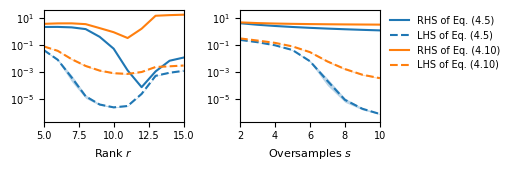

In [6]:
data = pickle.load(open("randRRR_errorbounds_dual_cpu.pkl", "rb"))

bounds_labels = ['LHS of Eq. (4.5)', 'LHS of Eq. (4.10)']
risks_labels = ['RHS of Eq. (4.5)', 'RHS of Eq. (4.10)']
x_labels = ['Rank $r$', 'Oversamples $s$']

fig_width = 4 #Inches
fig_height = 1.75 #Inches

fig, axes = plt.subplots(ncols=len(data),figsize=(fig_width, fig_height))

for idx in range(len(data)):
    ax = axes[idx]
    results = data[idx]['results'] 
    values = data[idx]['params_grid'].param_grid[0][data[idx]['name']]
    for data_idx, sampling_strategy in enumerate(results):
        th_estimate = sampling_strategy['th_estimate']
        means = sampling_strategy['means']
        stds = sampling_strategy['stds']
        means, risk_min, risk_max = mean_confidence_interval(sampling_strategy['risk_deltas'], confidence=0.95)
        
        if idx == 0:
            ax.plot(values, th_estimate, '-', color=cycle[data_idx])
            ax.plot(values, means, '--', color=cycle[data_idx])
        else:
            ax.plot(values, th_estimate, '-', color=cycle[data_idx], label=risks_labels[data_idx])
            ax.plot(values, means, '--', color=cycle[data_idx], label=bounds_labels[data_idx])

        ax.fill_between(values, risk_min, risk_max, alpha=0.3, color=cycle[data_idx], linewidth=0)

    ax.set_xlabel(x_labels[idx])
    ax.set_yscale('log')
    ax.set_xmargin(0)
    ax.set_ylim(2e-7, 40)

fig.legend(bbox_to_anchor=(0.97, 0.97, .28, -0.05), borderaxespad=0, loc='upper left', mode='expand', ncol=1, frameon=False)
plt.tight_layout()
fig.savefig("randRRR_errorbounds_dual_cpu.pdf",  bbox_inches='tight')

### Running second experiment (Figure 2)

In [9]:
cuda = False
double_precision = True
device = 'cuda' if cuda else 'cpu'
torch.set_default_device(device)
dtype = torch.DoubleTensor if double_precision else torch.FloatTensor
torch.set_default_tensor_type(dtype)

num_repetitions = 10
ndim = 100
num_samples_list = np.concatenate([np.arange(100, 1000, 100), np.arange(1000, 10001, 1000)])
decay_len = 5
rank = 10

# Generation of the low-rank estimator A
A = make_rand_mat(ndim, decay_len, rank, seed=0)
Xtest, Ytest = make_dataset(A, 1000, sigma=0.1, seed=42)

test_error_R3 = np.zeros(len(num_samples_list))
test_error_R4 = np.zeros((len(num_samples_list), num_repetitions))
train_error_R3 = np.zeros(len(num_samples_list))
train_error_R4 = np.zeros((len(num_samples_list), num_repetitions))
ET_R3 = np.zeros((len(num_samples_list), num_repetitions))
ET_R4 = np.zeros((len(num_samples_list), num_repetitions))
for rep_idx, num_samples in enumerate(num_samples_list):
    print(f"Currently processing num_samples: {num_samples}")
    #Generation of the low-rank estimator A
    X, Y = make_dataset(A, num_samples, sigma=0.1, seed=0)

    n = X.shape[0]
    kernel = LinearKernel()
    K_X = kernel(X)
    K_Y = kernel(Y)

    args = {'K_X': K_X, 'K_Y': K_Y, 'tikhonov_reg': 1e-6, 'rank': 15, 'svd_solver': 'arnoldi',
            '_return_singular_values': False}
    exec_time, _, _ = time_fn_execution(fit_R3, args, num_repetitions)
    U_R3, V_R3 = fit_R3(**args)
    train_error_R3[rep_idx] = risk(U_R3, V_R3, X, Y, kernel=kernel)
    test_error_R3[rep_idx] = risk(U_R3, V_R3, X, Y, kernel=kernel, Xtest=Xtest, Ytest=Ytest)
    ET_R3[rep_idx] = exec_time

    args = {'K_X': K_X, 'K_Y': K_Y, 'tikhonov_reg': 1e-6, 'rank': 15, 'n_oversamples': 20, 'iterated_power': 1,
            'rng_seed': None, 'optimal_sketching': False, '_return_singular_values': False}
    exec_time, train_error, test_error = time_fn_execution(fit_R4, args, num_repetitions)
    test_error_R4[rep_idx] = test_error
    train_error_R4[rep_idx] = train_error
    ET_R4[rep_idx, :] = exec_time

results = {
    'num_samples_list': num_samples_list.copy(),
    'ET_R3': ET_R3.copy(),
    'ET_R4': ET_R4.copy(),
    'test_error_R3': test_error_R3.copy(),
    'train_error_R3': train_error_R3.copy(),
    'test_error_R4': test_error_R4.copy(),
    'train_error_R4': train_error_R4.copy()
}

pickle.dump(results, open('randRRR_timings_dual_'+device+'.pkl', 'wb'))

Currently processing num_samples: 100


100%|██████████| 10/10 [00:00<00:00, 305.50it/s]


Currently processing num_samples: 200


100%|██████████| 10/10 [00:00<00:00, 223.71it/s]


Currently processing num_samples: 300


100%|██████████| 10/10 [00:00<00:00, 187.09it/s]


Currently processing num_samples: 400


100%|██████████| 10/10 [00:00<00:00, 151.17it/s]


Currently processing num_samples: 500


100%|██████████| 10/10 [00:00<00:00, 122.10it/s]


Currently processing num_samples: 600


100%|██████████| 10/10 [00:00<00:00, 101.09it/s]


Currently processing num_samples: 700


100%|██████████| 10/10 [00:00<00:00, 80.80it/s]


Currently processing num_samples: 800


100%|██████████| 10/10 [00:00<00:00, 67.51it/s]


Currently processing num_samples: 900


100%|██████████| 10/10 [00:00<00:00, 55.09it/s]


Currently processing num_samples: 1000


100%|██████████| 10/10 [00:00<00:00, 43.59it/s]


Currently processing num_samples: 2000


100%|██████████| 10/10 [00:00<00:00, 10.66it/s]


Currently processing num_samples: 3000


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Currently processing num_samples: 4000


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Currently processing num_samples: 5000


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Currently processing num_samples: 6000


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Currently processing num_samples: 7000


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Currently processing num_samples: 8000


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Currently processing num_samples: 9000


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Currently processing num_samples: 10000


100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


### Plotting Figure 2

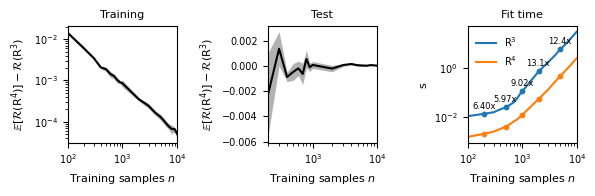

In [11]:
data = pickle.load(open("randRRR_timings_dual_cpu.pkl", "rb"))
labels = ['Standard Normal sketching']

fig_width = 6 #Inches
fig_height = 2 #Inches

fig, axs = plt.subplots(ncols=3,figsize=(fig_width, fig_height))

skip = 0
values = data['num_samples_list'][skip:]
ET_R3 = data['ET_R3'][skip:]
ET_R4 = data['ET_R4'][skip:]
test_error_R3 = data['test_error_R3'][skip:]
test_error_R4 = data['test_error_R4'][skip:]
train_error_R3 = data['train_error_R3'][skip:]
train_error_R4 = data['train_error_R4'][skip:]

means_R3 = ET_R3.mean(axis=1)
means_R4 = ET_R4.mean(axis=1)
stds_R3 = ET_R3.std(axis=1)
stds_R4 = ET_R4.std(axis=1)

delta_test_error = test_error_R4 - test_error_R3[:,None]
delta_train_error = train_error_R4 - train_error_R3[:,None]

means_test_error, risk_min_test_error, risk_max_test_error = mean_confidence_interval(delta_test_error, confidence=0.95)
means_train_error, risk_min_train_error, risk_max_train_error = mean_confidence_interval(delta_train_error, confidence=0.95)

axs[0].plot(values, means_train_error, '-', color='black')
axs[0].fill_between(values, risk_min_train_error, risk_max_train_error, alpha=0.3, color='black', linewidth=0)
axs[0].set_title("Training")
axs[0].set_xlabel("Training samples $n$")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xmargin(0)
axs[0].set_ylabel("$\mathbb{{E}}[\mathcal{R}(\mathrm{\mathsf{R}}^4)] - \mathcal{R}(\mathrm{\mathsf{R}}^3)$")

skip = 1
axs[1].plot(values[skip:], means_test_error[skip:], '-', color='black')
axs[1].fill_between(values[skip:], risk_min_test_error[skip:], risk_max_test_error[skip:], alpha=0.3, color='black', linewidth=0)
axs[1].set_title("Test")
axs[1].set_xlabel("Training samples $n$")
axs[1].set_xscale('log')
axs[1].set_xmargin(0)
axs[1].set_ylabel("$\mathbb{{E}}[\mathcal{R}(\mathrm{\mathsf{R}}^4)] - \mathcal{R}(\mathrm{\mathsf{R}}^3)$")


axs[2].plot(values, means_R3, '-', label='R$^3$', color=cycle[0])
axs[2].fill_between(values, means_R3 - stds_R3, means_R3 + stds_R3, alpha=0.3, color=cycle[0], linewidth=0)
axs[2].plot(values, means_R4, '-', label='R$^4$',color=cycle[1])
axs[2].fill_between(values, means_R4 - stds_R4, means_R4 + stds_R4, alpha=0.3, color=cycle[1], linewidth=0)
for i, el in enumerate(means_R3/means_R4):
    if np.isin(values[i], [200, 500,1000,2000,5000]):
        axs[2].text(values[i]*0.6, means_R3[i]*1.6, str(el)[:4]+'x', fontsize=6)
        axs[2].scatter(values[i], means_R3[i], color=cycle[0], s=10)
        axs[2].scatter(values[i], means_R4[i], color=cycle[1], s=10)
        
axs[2].set_title("Fit time")
axs[2].set_ylabel("s")
axs[2].set_xlabel("Training samples $n$")
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_xmargin(0)
axs[2].legend(frameon=False)

plt.tight_layout()
fig.savefig("results/toy_benchmark/randRRR_timings_cpu.pdf",  bbox_inches='tight')